# Process Reward Models

**Scoring each step, not just the final answer**

In the Fine-Tuning section, we built reward models that score complete responses. Give it a prompt and response, get a number: "this response is good" or "this response is bad."

That's an **Outcome Reward Model (ORM)**. It judges the destination, not the journey.

But for reasoning, the journey matters. A correct answer reached through flawed logic is a ticking time bomb. A **Process Reward Model (PRM)** scores each step along the way.

## ORM vs PRM

Consider this math solution:

```
Problem: What's 15% of 80?

Step 1: 15% means 15/100 = 0.15          ✓ (correct)
Step 2: Multiply: 0.15 × 80               ✓ (correct approach)
Step 3: 0.15 × 80 = 15 × 8 = 120         ✗ (wrong! should be 12)
Step 4: Wait, that's too high. Let me check: 0.15 × 80 = 12  ✓
Final answer: 12                          ✓ (correct)
```

**ORM sees**: Final answer is 12. Correct! Score: high.

**PRM sees**: Step 3 was wrong, but Step 4 caught and fixed it. Scores:
- Step 1: 1.0 (correct)
- Step 2: 1.0 (correct)
- Step 3: 0.0 (error!)
- Step 4: 1.0 (good correction)

The PRM gives us *much* more information. We know exactly where the reasoning went wrong.

## Why PRMs Matter

From OpenAI's "Let's Verify Step by Step" paper:

> Process supervision has several alignment advantages over outcome supervision. It directly rewards the model for following an aligned chain-of-thought, since each step in the process receives precise supervision.

Three key benefits:

### 1. Better Error Detection
ORMs can be fooled by wrong answers that "look right." PRMs catch logical errors even when the final answer happens to be correct.

### 2. More Precise Feedback
When training with RL, an ORM says "this whole response was good/bad." A PRM says "this specific step was the problem." Dense rewards lead to faster, more stable learning.

### 3. Interpretability
You can *see* where the model's reasoning breaks down. Useful for debugging and building trust.

The numbers: on the MATH benchmark, OpenAI's PRM achieved **78.2%** accuracy vs **72.4%** for their best ORM. A significant gap.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# Load base model for our PRM
model_name = "gpt2"
print(f"Loading {model_name} as base for PRM...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

device = "cuda" if torch.cuda.is_available() else "cpu"
base_model = base_model.to(device)

print(f"Loaded on {device}")

Loading gpt2 as base for PRM...


Loaded on cuda


## PRM Architecture

A PRM is similar to an ORM (from our reward modeling notebook), but with one key difference: it outputs a score for *each step*, not just one score for the whole response.

The architecture:

```
Input: [problem] [step 1] [step 2] ... [step N]
              │       │        │           │
              ▼       ▼        ▼           ▼
       ┌─────────────────────────────────────┐
       │          Base Language Model         │
       │         (GPT, LLaMA, etc.)          │
       └─────────────────────────────────────┘
              │       │        │           │
              ▼       ▼        ▼           ▼
            h_0     h_1      h_2         h_N   (hidden states)
                      │        │           │
                      ▼        ▼           ▼
                   score_1  score_2    score_N  (via value head)
```

We need to:
1. Identify where each step *ends* in the token sequence
2. Extract the hidden state at those positions
3. Run each through a value head to get step scores

In [2]:
class ProcessRewardModel(nn.Module):
    """
    Process Reward Model — scores each reasoning step.
    
    Unlike an ORM which gives one score for the whole response,
    a PRM gives a score for each step in the reasoning chain.
    """
    
    def __init__(self, base_model, hidden_size: int, 
                 step_separator: str = "\n"):
        super().__init__()
        self.base_model = base_model
        self.step_separator = step_separator
        
        # Value head: maps hidden state → step score
        self.value_head = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )
    
    def find_step_positions(self, input_ids: torch.Tensor,
                            tokenizer) -> List[List[int]]:
        """
        Find the token positions where each step ends.
        
        We look for newline tokens (or whatever separator is used)
        and return their positions.
        
        Args:
            input_ids: Token IDs, shape (batch, seq_len)
            tokenizer: The tokenizer (to find separator token)
        
        Returns:
            List of lists: step end positions for each sequence
        """
        # Get token ID for the separator
        sep_ids = tokenizer.encode(self.step_separator, add_special_tokens=False)
        
        batch_positions = []
        for seq in input_ids:
            positions = []
            for i, token_id in enumerate(seq):
                if token_id.item() in sep_ids:
                    positions.append(i)
            # Also include the last position (end of sequence)
            seq_len = (seq != tokenizer.pad_token_id).sum().item()
            if seq_len - 1 not in positions:
                positions.append(seq_len - 1)
            batch_positions.append(positions)
        
        return batch_positions
    
    def forward(self, input_ids: torch.Tensor, 
                attention_mask: torch.Tensor,
                tokenizer) -> Tuple[torch.Tensor, List[List[int]]]:
        """
        Compute step-level scores.
        
        Args:
            input_ids: Token IDs
            attention_mask: Attention mask
            tokenizer: Tokenizer for finding step boundaries
        
        Returns:
            (step_scores, step_positions)
            step_scores is a list of tensors (one per sequence)
        """
        # Get hidden states from base model
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        hidden_states = outputs.last_hidden_state  # (batch, seq, hidden)
        
        # Find step positions
        step_positions = self.find_step_positions(input_ids, tokenizer)
        
        # Extract hidden states at step positions and compute scores
        all_scores = []
        for batch_idx, positions in enumerate(step_positions):
            step_hidden = hidden_states[batch_idx, positions, :]  # (n_steps, hidden)
            scores = self.value_head(step_hidden).squeeze(-1)     # (n_steps,)
            all_scores.append(scores)
        
        return all_scores, step_positions


# Create PRM
prm = ProcessRewardModel(
    base_model=base_model,
    hidden_size=base_model.config.hidden_size,
    step_separator="\n"
)
prm = prm.to(device)

print(f"PRM created with {sum(p.numel() for p in prm.value_head.parameters()):,} value head parameters")

PRM created with 769 value head parameters


In [3]:
# Test the PRM on example reasoning
test_text = """Problem: What is 2 + 3?
Step 1: I need to add 2 and 3.
Step 2: 2 + 3 = 5.
Answer: 5"""

inputs = tokenizer(test_text, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    scores, positions = prm(
        inputs["input_ids"], 
        inputs["attention_mask"],
        tokenizer
    )

print("Test input:")
print(test_text)
print("\n" + "="*50)
print("\nStep scores (before training - essentially random):")

# Split text into steps for display
steps = test_text.split('\n')
for i, (step, score) in enumerate(zip(steps, scores[0])):
    print(f"  Step {i}: {score.item():.4f} — {step[:40]}...")

Test input:
Problem: What is 2 + 3?
Step 1: I need to add 2 and 3.
Step 2: 2 + 3 = 5.
Answer: 5


Step scores (before training - essentially random):
  Step 0: -5.4693 — Problem: What is 2 + 3?...
  Step 1: -4.0966 — Step 1: I need to add 2 and 3....
  Step 2: -3.5392 — Step 2: 2 + 3 = 5....
  Step 3: 1.1829 — Answer: 5...


/home/zhubert/intro-to-transformers/.venv/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:83: UserWarning: Flash Efficient attention on Current AMD GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:316.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/zhubert/intro-to-transformers/.venv/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:83: UserWarning: Mem Efficient attention on Current AMD GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:373.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


## Training a PRM

Training data for PRMs looks different from ORMs. Instead of:
```
(prompt, response_good, response_bad)
```

We need:
```
(prompt, solution_steps, step_labels)
```

Where `step_labels` marks each step as correct (+1) or incorrect (-1).

### Where does this data come from?

1. **Human annotation**: Pay people to label each step (expensive but high quality)
2. **Automatic labeling**: Use final answer correctness + heuristics
3. **Monte Carlo estimation**: Sample many continuations from each step, see which lead to correct answers

OpenAI's PRM800K dataset used human annotation — 800,000 step-level labels. That's a lot of work!

In [4]:
@dataclass
class PRMTrainingSample:
    """A training sample for the Process Reward Model."""
    problem: str
    steps: List[str]
    labels: List[int]  # +1 for correct, -1 for incorrect
    
    def to_text(self) -> str:
        """Convert to text format."""
        text = f"Problem: {self.problem}\n"
        for i, step in enumerate(self.steps):
            text += f"Step {i+1}: {step}\n"
        return text.strip()


# Create some synthetic training data
# In practice, you'd load this from a dataset like PRM800K

train_samples = [
    PRMTrainingSample(
        problem="What is 5 + 7?",
        steps=[
            "I need to add 5 and 7.",
            "5 + 7 = 12.",
            "The answer is 12."
        ],
        labels=[1, 1, 1]  # All correct
    ),
    PRMTrainingSample(
        problem="What is 8 × 3?",
        steps=[
            "I need to multiply 8 by 3.",
            "8 × 3 = 21.",  # Wrong!
            "The answer is 21."
        ],
        labels=[1, -1, -1]  # Step 2 is wrong, so step 3 is also wrong
    ),
    PRMTrainingSample(
        problem="What is 10 - 4?",
        steps=[
            "I need to subtract 4 from 10.",
            "10 - 4 = 6.",
            "The answer is 6."
        ],
        labels=[1, 1, 1]  # All correct
    ),
    PRMTrainingSample(
        problem="What is 15 / 3?",
        steps=[
            "I need to divide 15 by 3.",
            "15 / 3 = 3.",  # Wrong! Should be 5
            "Wait, let me recalculate: 15 / 3 = 5.",
            "The answer is 5."
        ],
        labels=[1, -1, 1, 1]  # Caught the error
    ),
]

print(f"Created {len(train_samples)} training samples")
print("\nExample sample:")
print(train_samples[1].to_text())
print(f"Labels: {train_samples[1].labels}")

Created 4 training samples

Example sample:
Problem: What is 8 × 3?
Step 1: I need to multiply 8 by 3.
Step 2: 8 × 3 = 21.
Step 3: The answer is 21.
Labels: [1, -1, -1]


## The PRM Loss Function

How do we train the PRM? We could use simple binary cross-entropy on each step:

$$\mathcal{L} = -\sum_{i=1}^{N} \left[ y_i \log(\sigma(s_i)) + (1 - y_i) \log(1 - \sigma(s_i)) \right]$$

Where:
- $s_i$ is the raw score for step $i$
- $y_i$ is the label (1 for correct, 0 for incorrect)
- $\sigma$ is the sigmoid function

But there's a subtlety. Steps aren't independent! If step 3 is wrong, everything after it is probably wrong too. We might want to:

1. Weight later steps more heavily (they're harder to get right)
2. Mask steps after the first error (they're "tainted")
3. Use a ranking loss between correct and incorrect steps

For simplicity, we'll use weighted binary cross-entropy.

In [5]:
def prm_loss(step_scores: List[torch.Tensor], 
             step_labels: List[List[int]],
             pos_weight: float = 1.0) -> torch.Tensor:
    """
    Compute PRM training loss.
    
    Uses binary cross-entropy for each step.
    
    Args:
        step_scores: List of score tensors (one per sequence)
        step_labels: List of label lists (+1 correct, -1 incorrect)
        pos_weight: Weight for positive examples
    
    Returns:
        Average loss across all steps
    """
    total_loss = 0.0
    n_steps = 0
    
    for scores, labels in zip(step_scores, step_labels):
        # Convert labels from [-1, 1] to [0, 1]
        targets = torch.tensor(
            [(l + 1) / 2 for l in labels], 
            device=scores.device,
            dtype=torch.float
        )
        
        # Handle case where we have more positions than labels
        n = min(len(scores), len(targets))
        scores = scores[:n]
        targets = targets[:n]
        
        # Binary cross-entropy loss
        # We apply sigmoid inside BCEWithLogitsLoss for numerical stability
        loss = F.binary_cross_entropy_with_logits(
            scores, targets,
            pos_weight=torch.tensor([pos_weight], device=scores.device)
        )
        
        total_loss += loss * n
        n_steps += n
    
    return total_loss / max(n_steps, 1)


# Test the loss function
dummy_scores = [torch.tensor([0.5, -0.3, 0.8], device=device)]
dummy_labels = [[1, -1, 1]]

loss = prm_loss(dummy_scores, dummy_labels)
print(f"Example loss: {loss.item():.4f}")

Example loss: 0.4665


In [6]:
def train_prm_epoch(prm: ProcessRewardModel, 
                    samples: List[PRMTrainingSample],
                    optimizer: torch.optim.Optimizer,
                    tokenizer) -> float:
    """
    Train PRM for one epoch.
    
    Args:
        prm: The process reward model
        samples: Training samples
        optimizer: The optimizer
        tokenizer: Tokenizer
    
    Returns:
        Average loss for the epoch
    """
    prm.train()
    total_loss = 0.0
    
    for sample in samples:
        # Tokenize
        text = sample.to_text()
        inputs = tokenizer(text, return_tensors="pt", padding=True).to(device)
        
        # Forward pass
        step_scores, _ = prm(
            inputs["input_ids"],
            inputs["attention_mask"],
            tokenizer
        )
        
        # Compute loss
        loss = prm_loss(step_scores, [sample.labels])
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(samples)


# Train for a few epochs
optimizer = torch.optim.AdamW(prm.parameters(), lr=1e-4)

print("Training PRM...")
print("="*40)

for epoch in range(10):
    loss = train_prm_epoch(prm, train_samples, optimizer, tokenizer)
    if epoch % 2 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")

print("\nTraining complete!")

Training PRM...


Epoch 1: Loss = 2.1061


Epoch 3: Loss = 0.5793


Epoch 5: Loss = 0.5728


Epoch 7: Loss = 0.3767


Epoch 9: Loss = 0.4649

Training complete!


In [7]:
# Test the trained PRM
prm.eval()

test_samples = [
    # Correct solution
    PRMTrainingSample(
        problem="What is 6 + 4?",
        steps=["I need to add 6 and 4.", "6 + 4 = 10.", "The answer is 10."],
        labels=[1, 1, 1]
    ),
    # Incorrect solution
    PRMTrainingSample(
        problem="What is 9 × 2?",
        steps=["I need to multiply 9 by 2.", "9 × 2 = 16.", "The answer is 16."],
        labels=[1, -1, -1]
    ),
]

print("Testing trained PRM:")
print("="*60)

for sample in test_samples:
    text = sample.to_text()
    inputs = tokenizer(text, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        scores, _ = prm(inputs["input_ids"], inputs["attention_mask"], tokenizer)
    
    print(f"\nProblem: {sample.problem}")
    for i, (step, score, label) in enumerate(zip(sample.steps, scores[0], sample.labels)):
        prob = torch.sigmoid(score).item()
        correct = "✓" if label == 1 else "✗"
        print(f"  Step {i+1}: P(correct)={prob:.2f} [{correct}] {step[:35]}...")

Testing trained PRM:

Problem: What is 6 + 4?
  Step 1: P(correct)=1.00 [✓] I need to add 6 and 4....
  Step 2: P(correct)=0.62 [✓] 6 + 4 = 10....
  Step 3: P(correct)=0.82 [✓] The answer is 10....

Problem: What is 9 × 2?
  Step 1: P(correct)=0.97 [✓] I need to multiply 9 by 2....
  Step 2: P(correct)=0.08 [✗] 9 × 2 = 16....
  Step 3: P(correct)=0.18 [✗] The answer is 16....


## Aggregating Step Scores

Once we have step-level scores, we need to aggregate them into an overall solution score. Common approaches:

### 1. Minimum (most conservative)
$$\text{score}_{\min} = \min_i P(\text{step}_i \text{ is correct})$$

If any step is wrong, the whole solution is suspicious.

### 2. Product (independence assumption)
$$\text{score}_{\text{prod}} = \prod_i P(\text{step}_i \text{ is correct})$$

Probability that *all* steps are correct, assuming independence.

### 3. Last step
$$\text{score}_{\text{last}} = P(\text{step}_N \text{ is correct})$$

If the final step is right, earlier steps were probably right too.

### 4. Weighted average
$$\text{score}_{\text{avg}} = \sum_i w_i \cdot P(\text{step}_i \text{ is correct})$$

With weights decreasing for later steps (errors compound).

In [8]:
def aggregate_prm_scores(step_probs: torch.Tensor, 
                         method: str = "min") -> float:
    """
    Aggregate step-level probabilities into a solution score.
    
    Args:
        step_probs: Probability of each step being correct
        method: Aggregation method ("min", "prod", "last", "mean")
    
    Returns:
        Overall solution score
    """
    if len(step_probs) == 0:
        return 0.0
    
    if method == "min":
        return step_probs.min().item()
    elif method == "prod":
        return step_probs.prod().item()
    elif method == "last":
        return step_probs[-1].item()
    elif method == "mean":
        return step_probs.mean().item()
    else:
        raise ValueError(f"Unknown method: {method}")


# Compare aggregation methods
# Simulated step probabilities: [0.95, 0.90, 0.30, 0.85]
# (Step 3 is suspicious)

step_probs = torch.tensor([0.95, 0.90, 0.30, 0.85])

print("Step probabilities:", [f"{p:.2f}" for p in step_probs.tolist()])
print("\nAggregation methods:")
print(f"  min:  {aggregate_prm_scores(step_probs, 'min'):.3f}  ← catches the bad step")
print(f"  prod: {aggregate_prm_scores(step_probs, 'prod'):.3f}  ← heavily penalized")
print(f"  last: {aggregate_prm_scores(step_probs, 'last'):.3f}  ← misses the error!")
print(f"  mean: {aggregate_prm_scores(step_probs, 'mean'):.3f}  ← smoothed")

Step probabilities: ['0.95', '0.90', '0.30', '0.85']

Aggregation methods:
  min:  0.300  ← catches the bad step
  prod: 0.218  ← heavily penalized
  last: 0.850  ← misses the error!
  mean: 0.750  ← smoothed


## Using PRMs for Verification

Now let's put it together: use the PRM to verify reasoning chains and select the best one.

In [9]:
class PRMVerifier:
    """
    Use a PRM to verify and rank reasoning chains.
    """
    
    def __init__(self, prm: ProcessRewardModel, tokenizer,
                 aggregation: str = "min"):
        self.prm = prm
        self.tokenizer = tokenizer
        self.aggregation = aggregation
    
    def score_solution(self, problem: str, steps: List[str]) -> dict:
        """
        Score a complete solution.
        
        Returns step scores and aggregated score.
        """
        # Format as text
        text = f"Problem: {problem}\n"
        for i, step in enumerate(steps):
            text += f"Step {i+1}: {step}\n"
        
        # Tokenize and score
        inputs = self.tokenizer(text, return_tensors="pt", padding=True)
        inputs = {k: v.to(next(self.prm.parameters()).device) for k, v in inputs.items()}
        
        self.prm.eval()
        with torch.no_grad():
            scores, _ = self.prm(
                inputs["input_ids"],
                inputs["attention_mask"],
                self.tokenizer
            )
        
        # Convert to probabilities
        step_probs = torch.sigmoid(scores[0][:len(steps)])
        overall_score = aggregate_prm_scores(step_probs, self.aggregation)
        
        return {
            "step_probs": step_probs.tolist(),
            "overall_score": overall_score,
            "weakest_step": step_probs.argmin().item(),
            "weakest_prob": step_probs.min().item()
        }
    
    def rank_solutions(self, problem: str, 
                       solutions: List[List[str]]) -> List[dict]:
        """
        Rank multiple solutions by PRM score.
        
        Args:
            problem: The problem statement
            solutions: List of step lists
        
        Returns:
            Ranked list of (solution_idx, score_info) dicts
        """
        results = []
        for i, steps in enumerate(solutions):
            score_info = self.score_solution(problem, steps)
            score_info["solution_idx"] = i
            score_info["steps"] = steps
            results.append(score_info)
        
        # Sort by overall score (descending)
        results.sort(key=lambda x: x["overall_score"], reverse=True)
        return results


# Create verifier
verifier = PRMVerifier(prm, tokenizer, aggregation="min")
print("PRM Verifier ready.")

PRM Verifier ready.


In [10]:
# Test: rank multiple solutions to the same problem
problem = "What is 7 × 8?"

solutions = [
    # Solution 1: Correct
    [
        "I need to multiply 7 by 8.",
        "7 × 8 = 56.",
        "The answer is 56."
    ],
    # Solution 2: Wrong arithmetic
    [
        "I need to multiply 7 by 8.",
        "7 × 8 = 54.",  # Wrong!
        "The answer is 54."
    ],
    # Solution 3: Wrong but self-corrected
    [
        "I need to multiply 7 by 8.",
        "7 × 8 = 54.",  # Wrong
        "Wait, let me check: 7 × 8 = 56.",  # Corrected
        "The answer is 56."
    ],
]

print(f"Problem: {problem}")
print("\nRanking 3 different solutions...")
print("="*60)

ranked = verifier.rank_solutions(problem, solutions)

for rank, result in enumerate(ranked, 1):
    print(f"\nRank {rank}: Solution {result['solution_idx'] + 1}")
    print(f"  Overall score: {result['overall_score']:.3f}")
    print(f"  Step probs: {[f'{p:.2f}' for p in result['step_probs']]}")
    print(f"  Weakest: Step {result['weakest_step'] + 1} (p={result['weakest_prob']:.2f})")
    print(f"  Steps: {result['steps'][0][:30]}...")

Problem: What is 7 × 8?

Ranking 3 different solutions...



Rank 1: Solution 1
  Overall score: 0.094
  Step probs: ['0.98', '0.09', '0.21']
  Weakest: Step 2 (p=0.09)
  Steps: I need to multiply 7 by 8....

Rank 2: Solution 2
  Overall score: 0.094
  Step probs: ['0.98', '0.09', '0.19']
  Weakest: Step 2 (p=0.09)
  Steps: I need to multiply 7 by 8....

Rank 3: Solution 3
  Overall score: 0.094
  Step probs: ['0.98', '0.09', '0.19', '0.33']
  Weakest: Step 2 (p=0.09)
  Steps: I need to multiply 7 by 8....


## Visualizing PRM Scores

One of the great things about PRMs is interpretability. Let's visualize where the model thinks errors might be.

Problem: What is 12 / 4?
(Correct answer: 3)


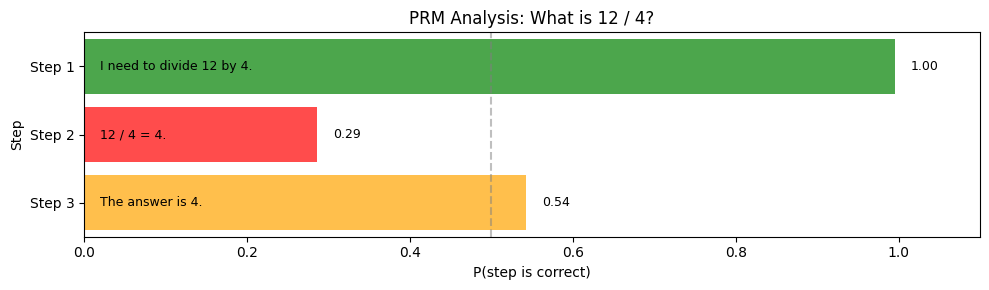

In [11]:
def visualize_prm_scores(steps: List[str], probs: List[float], 
                         title: str = "PRM Step Scores"):
    """
    Visualize PRM scores for a solution.
    """
    n_steps = len(steps)
    
    fig, ax = plt.subplots(figsize=(10, max(3, n_steps * 0.5)))
    
    # Create horizontal bar chart
    y_pos = np.arange(n_steps)
    colors = ['green' if p > 0.7 else 'orange' if p > 0.4 else 'red' for p in probs]
    
    bars = ax.barh(y_pos, probs, color=colors, alpha=0.7)
    
    # Add step labels
    for i, (step, prob) in enumerate(zip(steps, probs)):
        # Truncate long steps
        step_text = step[:50] + "..." if len(step) > 50 else step
        ax.text(0.02, i, step_text, va='center', fontsize=9)
        ax.text(prob + 0.02, i, f"{prob:.2f}", va='center', fontsize=9)
    
    ax.set_xlim(0, 1.1)
    ax.set_ylim(-0.5, n_steps - 0.5)
    ax.set_xlabel("P(step is correct)")
    ax.set_ylabel("Step")
    ax.set_title(title)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"Step {i+1}" for i in range(n_steps)])
    ax.invert_yaxis()  # Top step first
    
    # Add threshold line
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# Visualize a solution with an error
problem = "What is 12 / 4?"
steps = [
    "I need to divide 12 by 4.",
    "12 / 4 = 4.",  # Wrong! Should be 3
    "The answer is 4."
]

result = verifier.score_solution(problem, steps)

print(f"Problem: {problem}")
print(f"(Correct answer: 3)")
visualize_prm_scores(steps, result["step_probs"], 
                     title=f"PRM Analysis: {problem}")

## What We've Learned

Process Reward Models provide step-level supervision:

1. **Architecture**: Base LM + value head, scoring at step boundaries
2. **Training**: Binary classification on step correctness
3. **Aggregation**: Combine step scores (min, product, mean, last)
4. **Verification**: Rank solutions by PRM score

Key insight from OpenAI:

> Process supervision leads to significantly better performance, even when judged by outcomes.

The math:
$$\mathcal{L} = -\sum_{i=1}^{N} \left[ y_i \log(\sigma(s_i)) + (1 - y_i) \log(1 - \sigma(s_i)) \right]$$

PRMs are essential for:
- Guiding search (which path is promising?)
- Best-of-N selection (which solution is most reliable?)
- RLHF with dense rewards (step-level feedback)

**Next up:** Best-of-N with verification — using PRMs to select the best solution from many candidates